In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns

In [49]:
# delta time (timestep)
dt = 0.001
# Number of time steps
ndt = 400
# Length
L = 1
# Number of grids == number of nodes-1
ndx = 4
ndy = 5
m = ndx*ndy
dx = 1
dy = 1
# boundary conditions pressure (numpy array with a length of 2)
bc_pressure = np.array([1, 0])
# Static rock properties
phi = 0.2
kx = 2
ky = 2
# fluid properties
mu = 1
rho = 62.4

cp = 1e-6*mu*phi/kx

In [51]:
ij_to_m = lambda i, j: (j-1)*ndx+i # convert poisition to m

In [52]:
ijpy_to_m = lambda i, j: (j)*ndx+i+1 # convert pythonic position (index starts from zero) to m

In [53]:
# list of all coordinations (i,j) and m
ijpy_m = []
for j in range(ndy):
    for i in range(ndx):
        ijpy_m.append(( (i, j), ijpy_to_m(i, j)))

In [54]:
# Check whether the block is a boundary grid block
def is_exterior(i, j):
    if i==0 or i==ndx-1 or j==0 or j==ndy-1:
        return True
    else:
        return False

In [55]:
# Check whether the block is inactive
def is_active(i, j):
    if i<0 or i>=ndx or j<0 or j>=ndy:
        return False
    else:
        return True

In [71]:
tolerance = 1e-4
pi = 2000
ndt = 100
all_A = []
pressure_grid = np.ones([ndx, ndy, ndt]) * pi
well_coords = (1,1)
# Create matrix A
A_m = np.zeros([m,m])
betha = np.zeros([m])
for t in range(ndt-1):
    A_m = np.zeros([m,m])
    betha = np.zeros([m])
    for n in range(m):
        i,j = ijpy_m[n][0]
        if ijpy_to_m(i-1, j)-1>=0 and is_active(i-1, j):
            A_m[n, ijpy_to_m(i-1, j)-1] = -kx*rho/(mu*dx*dx)

        if ijpy_to_m(i, j-1)-1>=0 and is_active(i, j-1):
            A_m[n, ijpy_to_m(i, j-1)-1] = -ky*rho/(mu*dy*dy)

        if ijpy_to_m(i+1, j)<=m and is_active(i+1, j):
            A_m[n, ijpy_to_m(i+1, j)-1] = -kx*rho/(mu*dx*dx)

        if ijpy_to_m(i, j+1)<=m and is_active(i, j+1):
            A_m[n, ijpy_to_m(i, j+1)-1] = -ky*rho/(mu*dy*dy)
        
        A_m[n, n] = cp/dt + kx*rho/(mu*dx*dx) + ky*rho/(mu*dy*dy) + kx*rho/(mu*dx*dx) + ky*rho/(mu*dy*dy)
        if is_exterior(i, j):
            if i==0:
                A_m[n, n] -= -kx*rho/(mu*dx*dx)
            if i==ndx-1:
                A_m[n, n] -= -kx*rho/(mu*dx*dx)
            if j==0:
                A_m[n, n] -= -ky*rho/(mu*dy*dy)
            if j==ndy-1:
                A_m[n, n] -= -ky*rho/(mu*dy*dy)
        betha[n] = cp*pressure_grid[i, j, t]/dt
        betha[ijpy_to_m(*well_coords)-1] -= 1
    if t==0:
        betha_zero = betha
    p = np.linalg.solve(A_m, betha)
    all_A.append(A_m)
    pressure_grid[:,:,t+1] = p.reshape(ndx, ndy, order='F').copy()

In [90]:
-ky*rho/(mu*dy*dy)

-124.8

In [78]:
np.linalg.solve(all_A[0], betha_zero)

array([-2.88349575e-03, -9.43242920e-03, -4.51987233e-03, -9.90908815e-04,
       -9.47111169e-03, -4.13613496e-02, -1.37785914e-02, -3.02814545e-03,
       -4.71328482e-03, -1.41735556e-02, -7.80757333e-03, -1.97379358e-03,
       -1.52432471e-03, -4.41458997e-03, -2.90692316e-03, -6.35814818e-04,
       -9.63141021e-05, -6.56124080e-04, -3.72280960e-04,  9.90780408e-05])

In [79]:
pressure_grid[:,:,1]

array([[-2.88349575e-03, -9.47111169e-03, -4.71328482e-03,
        -1.52432471e-03, -9.63141021e-05],
       [-9.43242920e-03, -4.13613496e-02, -1.41735556e-02,
        -4.41458997e-03, -6.56124080e-04],
       [-4.51987233e-03, -1.37785914e-02, -7.80757333e-03,
        -2.90692316e-03, -3.72280960e-04],
       [-9.90908815e-04, -3.02814545e-03, -1.97379358e-03,
        -6.35814818e-04,  9.90780408e-05]])

In [70]:
betha_zero

array([  0.2,   0.2,   0.2,   0.2,   0.2, -14.8,   0.2,   0.2,   0.2,
         0.2,   0.2,   0.2,   0.2,   0.2,   0.2,   0.2,   0.2,   0.2,
         0.2,   0.2])

In [64]:
betha

array([-3.50885680e-07, -1.04919603e-06, -5.57940161e-07, -1.61626886e-07,
       -1.05611805e-06, -1.50000043e+01, -1.57887789e-06, -4.11821156e-07,
       -5.92550294e-07, -1.64519444e-06, -1.00859595e-06, -3.18601003e-07,
       -2.61438973e-07, -6.42477232e-07, -4.91710454e-07, -1.72587913e-07,
       -7.21673386e-08, -1.71565059e-07, -1.43180724e-07, -5.26281061e-08])

In [57]:
-ky*rho/(mu*dy*dy)

-124.8

In [58]:
A_m[1,1]

624.0001

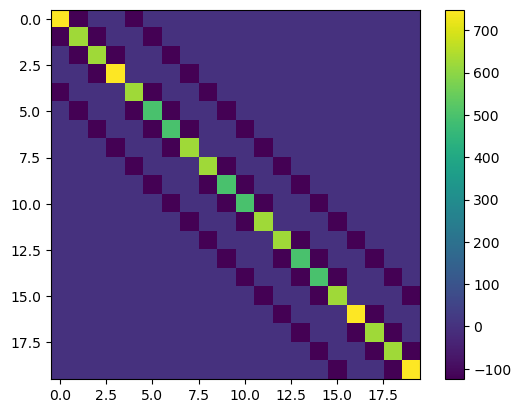

In [81]:
plt.imshow(all_A[0])
plt.colorbar()

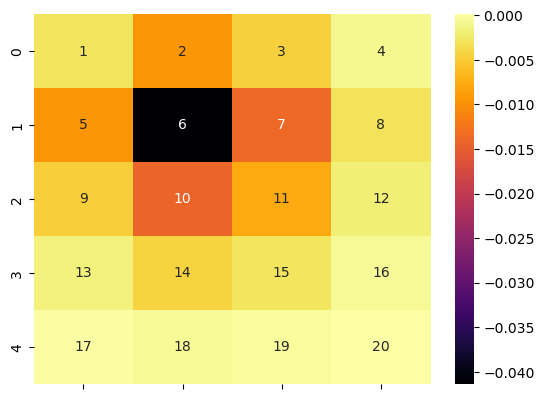

In [72]:
labels = [i+1 for i in range(20)]
labels = np.reshape(labels, (ndy, ndx))
time = 1
ax = sns.heatmap(pressure_grid[:,:,time].swapaxes(0, 1), cmap="inferno", cbar=True, annot=labels)
ax.set(xticklabels=[])
plt.show()


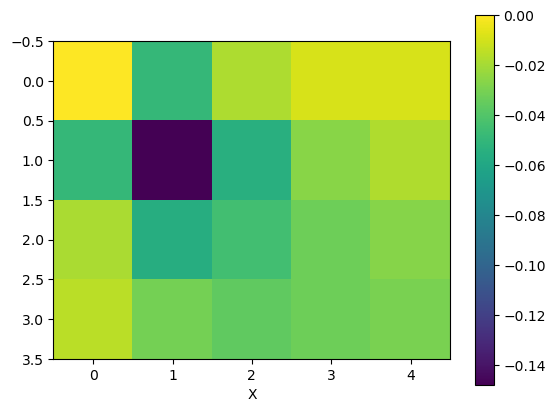

In [63]:
t = 10
plt.imshow(pressure_grid[:,:,t])
plt.xlabel('X')

plt.axis('on')
plt.colorbar()
plt.show()

### Constant BC Pressure=1500

In [50]:
tolerance = 1e-4
pi = 1000
pressure_grid = np.ones([ndx, ndy, ndt]) * pi
well_coords = (1,1)
# Create matrix A
A_m = np.zeros([m,m])
betha = np.zeros([m])
for t in range(ndt-1):
    A_m = np.zeros([m,m])
    betha = np.zeros([m])
    for n in range(m):
        i,j = ijpy_m[n][0]
        # if is_exterior(i, j):
            
        if ijpy_to_m(i-1, j)-1>=0:
            A_m[n, ijpy_to_m(i-1, j)-1] = -kx*rho/(mu*dx*dx)

        if ijpy_to_m(i, j-1)-1>=0:
            A_m[n, ijpy_to_m(i, j-1)-1] = -ky*rho/(mu*dy*dy)

        if ijpy_to_m(i+1, j)<=m:
            A_m[n, ijpy_to_m(i+1, j)-1] = -kx*rho/(mu*dx*dx)

        if ijpy_to_m(i, j+1)<=m:
            A_m[n, ijpy_to_m(i, j+1)-1] = -ky*rho/(mu*dy*dy)
            
        A_m[n, n] = cp/dt + kx*rho/(mu*dx*dx) + ky*rho/(mu*dy*dy) + kx*rho/(mu*dx*dx) + ky*rho/(mu*dy*dy)
        betha[n] = cp*pressure_grid[i, j, t]/dt
        betha[ijpy_to_m(*well_coords)-1] += 500
    p = np.linalg.solve(A_m, betha)
    pressure_grid[:,:,t+1] = p.reshape(ndx, ndy, order='F')

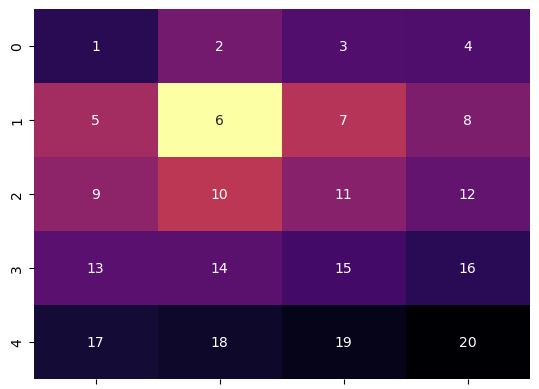

In [52]:
labels = [i+1 for i in range(20)]
labels = np.reshape(labels, (ndy, ndx))

ax = sns.heatmap(pressure_grid[:,:,-1].swapaxes(0, 1), cmap="inferno", cbar=False, annot=labels)
ax.set(xticklabels=[])
plt.show()
